### **Spatially Aware Modelling for Data-Driven Gym Membership Demand Estimation**
**Sayantan Bal**

**Own Work Declaration**

I confirm that the work contained in this report is my own except where otherwise indicated.


**Executive Summary**

This project developed a predictive model to estimate gym membership across UK locations by integrating spatial, demographic, and behavioural data. Key factors influencing membership include local population density shifts, average user spend, transaction activity, gym type, and accessibility. The model incorporates seasonal trends and pricing sensitivity to reflect real-world dynamics. A spatial-pricing tool derived from this model enables data-driven decisions around site selection, pricing optimization, and operational planning—supporting strategic growth and improved resource allocation.

**Exploratory & Initial Data Analysis**

In [ ]:
# Start
# Data Manipulation & Processing
import pandas as pd
import numpy as np
import warnings

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Machine Learning & Statistical Modeling
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, r2_score, 
    mean_absolute_error, explained_variance_score
)
from scipy.spatial import KDTree

# Probabilistic Programming & Bayesian Inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import jax.random as jrandom

# Geospatial Analysis
import geopandas as gpd
from shapely.geometry import Point

# Utilities & Output Formatting
from tabulate import tabulate

# Suppress warning messages
warnings.filterwarnings('ignore')

In [5]:
# Read CSV into a Data Frame
df = pd.read_csv('Uoe_data_all.csv')
df.head()

,StartMonth,Total Members,GymUsableSqFt,GymMaxOccupancy,GymSiteType,GymParking,unis_within_0_0.5_mile,unis_within_0.5_1_mile,unis_within_1_2_mile,PromoPercentage,...,txn_density_0_1_mi,txn_count_1_2_mi,txn_density_1_2_mi,txn_count_2_3_mi,txn_density_2_3_mi,txn_count_3_4_mi,txn_density_3_4_mi,Latitude,Longitude,HashedGymPublicName
0,2024-01,3373,7438.0,124.0,Residential,Parking,1,0,0,0.644281,...,1031.324031,513,54.430991,716,45.581976,1799,81.805641,53.752142,-2.362499,303d35421b8d224ed997d4af7f0a0dfd189ac35c84b1d0...
1,2024-02,3439,7438.0,124.0,Residential,Parking,1,0,0,0.334465,...,1031.324031,513,54.430991,716,45.581976,1799,81.805641,53.752142,-2.362499,303d35421b8d224ed997d4af7f0a0dfd189ac35c84b1d0...
2,2024-03,3413,7438.0,124.0,Residential,Parking,1,0,0,0.431085,...,1031.324031,513,54.430991,716,45.581976,1799,81.805641,53.752142,-2.362499,303d35421b8d224ed997d4af7f0a0dfd189ac35c84b1d0...
3,2024-04,3547,7438.0,124.0,Residential,Parking,1,0,0,0.450350,...,1031.324031,513,54.430991,716,45.581976,1799,81.805641,53.752142,-2.362499,303d35421b8d224ed997d4af7f0a0dfd189ac35c84b1d0...
4,2024-05,3389,7438.0,124.0,Residential,Parking,1,0,0,0.401715,...,1031.324031,513,54.430991,716,45.581976,1799,81.805641,53.752142,-2.362499,303d35421b8d224ed997d4af7f0a0dfd189ac35c84b1d0...


Data

| SL. No. | Column Name              | Description                                                                 |
|---------|--------------------------|-----------------------------------------------------------------------------|
| 1       | Latitude                 | Latitude coordinate of gym location                                        |
| 2       | Longitude                | Longitude coordinate of gym location                                       |
| 3       | HashedGymPublicName     | Encrypted gym identifier                                                   |
| 4       | StartMonth              | Month of counting the memberships                                          |
| 5       | Total Members           | Total number of active gym members                                         |
| 6       | GymUsableSqFt           | Usable square footage of the gym                                           |
| 7       | GymMaxOccupancy         | Maximum legal occupancy for the gym facility                               |
| 8       | GymSiteType             | Type of gym location                                                       |
| 9       | GymParking              | Parking availability or capacity at the gym site                           |
| 10      | unis_within_0_0.5_mile  | Number of universities within 0–0.5-mile radius                            |
| 11      | unis_within_0.5_1_mile  | Number of universities within 0.5–1-mile radius                            |
| 12      | unis_within_1_2_mile    | Number of universities within 1–2-mile radius                              |
| 13      | PromoPercentage         | Percentage of promotion acquired via promotional offers in that month      |
| 14      | AvgJoiningFee           | Average joining fee charged to new members                                 |
| 15      | AvgAccountPayment       | Average ongoing monthly account payment                                    |
| 16      | UMAP2D_1                | Compressed demographic features for population nearby (1)                  |
| 17      | UMAP2D_2                | Compressed demographic features for population nearby (2)                  |
| 18      | BASEADL_0.5             | Total population within 0.5-mile radius                                    |
| 19      | POP_0.5_1               | Population in the 0.5–1 mile ring                                          |
| 20      | POP_1_2                 | Population in the 1–2-mile ring                                            |
| 21      | POP_2_3                 | Population in the 2–3-mile ring                                            |
| 22      | POP_3_4                 | Population in the 3–4-mile ring                                            |
| 23      | DENS_0_0.5              | Population density within 0–0.5 mile                                       |
| 24      | DENS_0.5_1              | Population density within 0.5–1 mile                                       |
| 25      | DENS_1_2                | Population density within 1–2 mile                                         |
| 26      | DENS_2_3                | Population density within 2–3 mile                                         |
| 27      | DENS_3_4                | Population density within 3–4 mile                                         |
| 28      | DENSITY_DROP_2          | Drop in population density from 0.5–1 to 1–2 mile                          |
| 29      | DENSITY_DROP_3          | Drop in population density from 1–2 to 2–3 mile                            |
| 30      | DENSITY_DROP_4          | Drop in population density from 2–3 to 3–4 mile                            |
| 31      | NEAR_POP_SHARE          | Share of 0.5-mile population relative to 4-mile population                 |
| 32      | INNER_RING_SHARE        | Share of 1 mile population relative to 4-mile population                   |
| 33      | RATIO_0_5_TO_1          | Ratio of population in 0–0.5-mile ring to 0.5–1 mile ring                  |
| 34      | RATIO_1_TO_2            | Ratio of population in 0.5–1 mile ring to 1–2-mile ring                    |
| 35      | 0-0.5_mile_comp         | Number of competitor gyms within 0–0.5 mile                                |
| 36      | 0.5-1_mile_comp         | Number of competitor gyms within 0.5–1 mile                                |
| 37      | 1-2_mile_comp           | Number of competitor gyms within 1–2 mile                                  |
| 38      | CompetitorIndex         | Composite score quantifying competitive intensity                          |
| 39      | transaction_density_4   | Transaction density within a 4-mile radius                                 |
| 40      | user_density            | Density of gym users in the nearby area                                    |
| 41      | avg_spend_per_user      | Average spends per user in the area                                        |
| 42      | user_repeat_rate        | Proportion of repeat users                                                 |
| 43      | distance_weighted_spend | User spend weighted by proximity at the gym                                |
| 44      | avg_merchant_per_user   | Average number of gyms used by each user in the locality                   |
| 45      | txn_count_0_1_mi        | Number of transactions within 0–1 mile                                     |
| 46      | txn_density_0_1_mi      | Transaction density within 0–1 mile                                        |
| 47      | txn_count_1_2_mi        | Number of transactions within 1–2 mile                                     |
| 48      | txn_density_1_2_mi      | Transaction density within 1–2 mile                                        |
| 49      | txn_count_2_3_mi        | Number of transactions within 2–3 mile                                     |
| 50      | txn_density_2_3_mi      | Transaction density within 2–3 mile                                        |
| 51      | txn_count_3_4_mi        | Number of transactions within 3–4 mile                                     |
| 52      | txn_density_3_4_mi      | Transaction density within 3–4 mile                                        |


In [6]:
df = df.dropna(subset=["Total Members"])  # Drop rows with missing Total Members
df["StartMonth"] = pd.to_datetime(df["StartMonth"])  # Convert StartMonth to datetime

# Describe the Dataset
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2832 entries, 0 to 2831
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   StartMonth               2832 non-null   datetime64[ns]
 1   Total Members            2832 non-null   int64         
 2   GymUsableSqFt            2832 non-null   float64       
 3   GymMaxOccupancy          2808 non-null   float64       
 4   GymSiteType              2832 non-null   object        
 5   GymParking               2832 non-null   object        
 6   unis_within_0_0.5_mile   2832 non-null   int64         
 7   unis_within_0.5_1_mile   2832 non-null   int64         
 8   unis_within_1_2_mile     2832 non-null   int64         
 9   PromoPercentage          2832 non-null   float64       
 10  AvgJoiningFee            2832 non-null   float64       
 11  AvgAccountPayment        2832 non-null   float64       
 12  BASEADL_0.5              2832 non-

,StartMonth,Total Members,GymUsableSqFt,GymMaxOccupancy,unis_within_0_0.5_mile,unis_within_0.5_1_mile,unis_within_1_2_mile,PromoPercentage,AvgJoiningFee,AvgAccountPayment,...,txn_count_0_1_mi,txn_density_0_1_mi,txn_count_1_2_mi,txn_density_1_2_mi,txn_count_2_3_mi,txn_density_2_3_mi,txn_count_3_4_mi,txn_density_3_4_mi,Latitude,Longitude
count,2832,2832.000000,2832.000000,2808.000000,2832.000000,2832.000000,2832.000000,2832.000000,2832.000000,2832.000000,...,2832.000000,2832.000000,2832.000000,2832.000000,2832.000000,2832.000000,2832.000000,2832.000000,2832.000000,2832.000000
mean,2024-06-16 08:00:00,5049.542373,12271.622881,193.619658,0.533898,1.131356,2.572034,0.541745,4.674619,38.698064,...,3134.016949,997.588578,5719.644068,606.873084,7723.991525,491.724573,9582.427966,435.740222,52.412302,-1.177717
min,2024-01-01 00:00:00,35.000000,5576.000000,82.000000,0.000000,0.000000,0.000000,0.207000,0.000000,20.215301,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.368952,-4.667534
25%,2024-03-24 06:00:00,4080.000000,10433.000000,163.000000,0.000000,0.000000,0.000000,0.456522,3.498841,30.733672,...,1751.250000,557.440188,2542.500000,269.767629,1774.750000,112.984094,1335.750000,60.740347,51.466296,-2.101061
50%,2024-06-16 00:00:00,5105.500000,12066.000000,191.500000,0.000000,0.000000,1.000000,0.535069,4.526120,35.822743,...,2825.000000,899.225428,4609.500000,489.083140,5423.000000,345.238903,5369.000000,244.143683,51.622413,-0.959386
75%,2024-09-08 12:00:00,6062.500000,14160.750000,222.000000,1.000000,1.000000,3.000000,0.621821,5.743020,42.870788,...,4302.750000,1369.607863,7679.250000,814.793731,12927.250000,822.974295,15869.000000,721.608512,53.381027,-0.127995
max,2024-12-01 00:00:00,9359.000000,22163.000000,317.000000,15.000000,22.000000,36.000000,1.050000,13.541667,163.571817,...,9630.000000,3065.324204,19352.000000,2053.310972,29841.000000,1899.737063,43435.000000,1975.112844,56.472931,1.718632
std,NaN,1411.126001,3213.934651,44.331161,1.400503,2.653359,5.052228,0.122061,1.687074,12.687494,...,1848.349268,588.347845,4304.630306,456.735461,7209.683164,458.982685,10406.776746,473.225703,1.440847,1.351839


**Principal Component Analysis**

Number of components to explain 95% variance: 19

Top features based on 19 components:
AvgAccountPayment         0.782730
unis_within_0_0.5_mile    0.627944
0-0.5_mile_comp           0.595982
AvgJoiningFee             0.564020
DENSITY_DROP_4            0.561009
avg_merchant_per_user     0.539977
PromoPercentage           0.500527
UMAP2D_1                  0.492373
DENSITY_DROP_3            0.450167
user_repeat_rate          0.442753
RATIO_0_5_TO_1            0.442671
GymMaxOccupancy           0.428261
DENSITY_DROP_2            0.402821
UMAP2D_2                  0.401495
GymUsableSqFt             0.381911
Latitude                  0.370531
avg_spend_per_user        0.358319
Longitude                 0.349438
txn_density_0_1_mi        0.332689
dtype: float64


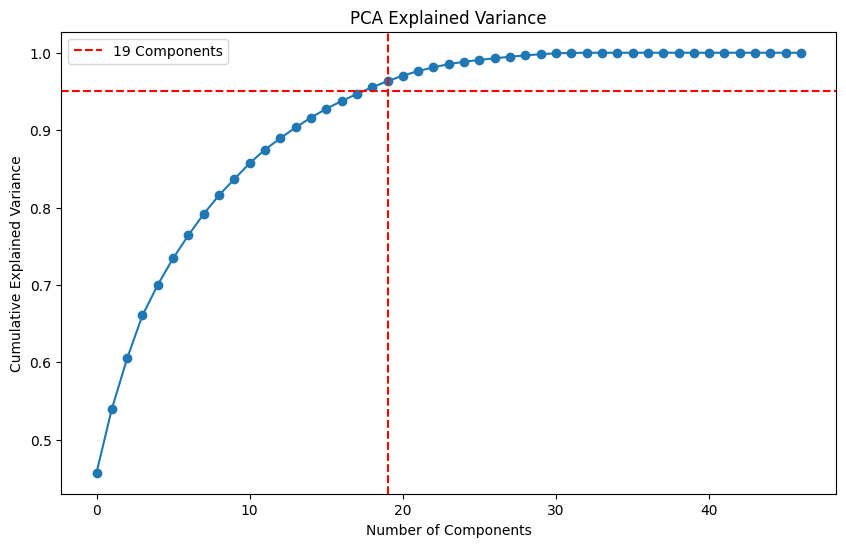

In [7]:
scaler = StandardScaler()
features = df.drop(columns=['HashedGymPublicName', 'StartMonth', 'Total Members','GymSiteType','GymParking'], errors='ignore')
features = features.fillna(features.mean())
scaled_data = scaler.fit_transform(features)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

explained_variance = pca.explained_variance_ratio_

# Determine number of components to reach 95% variance
cumulative_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components to explain 95% variance: {n_components}\n")

# Get PCA loadings for only those components
loadings = pca.components_[:n_components]

# Create DataFrame for feature importance
feature_importance = pd.DataFrame(np.abs(loadings).T, index=features.columns,
                                  columns=[f'PC{i+1}' for i in range(n_components)])

# For each feature, get max loading across selected PCs
top_features = feature_importance.max(axis=1).sort_values(ascending=False)

# Pick top N components
top_n_features = top_features.head(n_components)
print(f"Top features based on {n_components} components:")
print(top_n_features)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=n_components, color='r', linestyle='--', label=f'{n_components} Components')
plt.legend()
plt.show()

To reduce dimensionality and enhance model interpretability, we first applied Principal Component Analysis (PCA) to the dataset, which originally contained a large number of features. Since the presence of many potentially collinear variables can lead to overfitting and unnecessary model complexity, PCA was employed to identify the minimal number of components that capture the majority of variance in the data. Notably, only numerical features were considered in this analysis, as PCA is inherently designed for continuous variables. As shown in the cumulative explained variance plot, we observed that 19 components were sufficient to account for 95% of the total variance. Based on this threshold, we selected the top 19 contributing features—including `AvgAccountPayment`, `unis_within_0_0.5_mile`, and `0-0.5_mile_comp` — as the most informative. These features will be used in modeling to ensure efficiency without compromising predictive power.

**Numerical Feature Analysis**

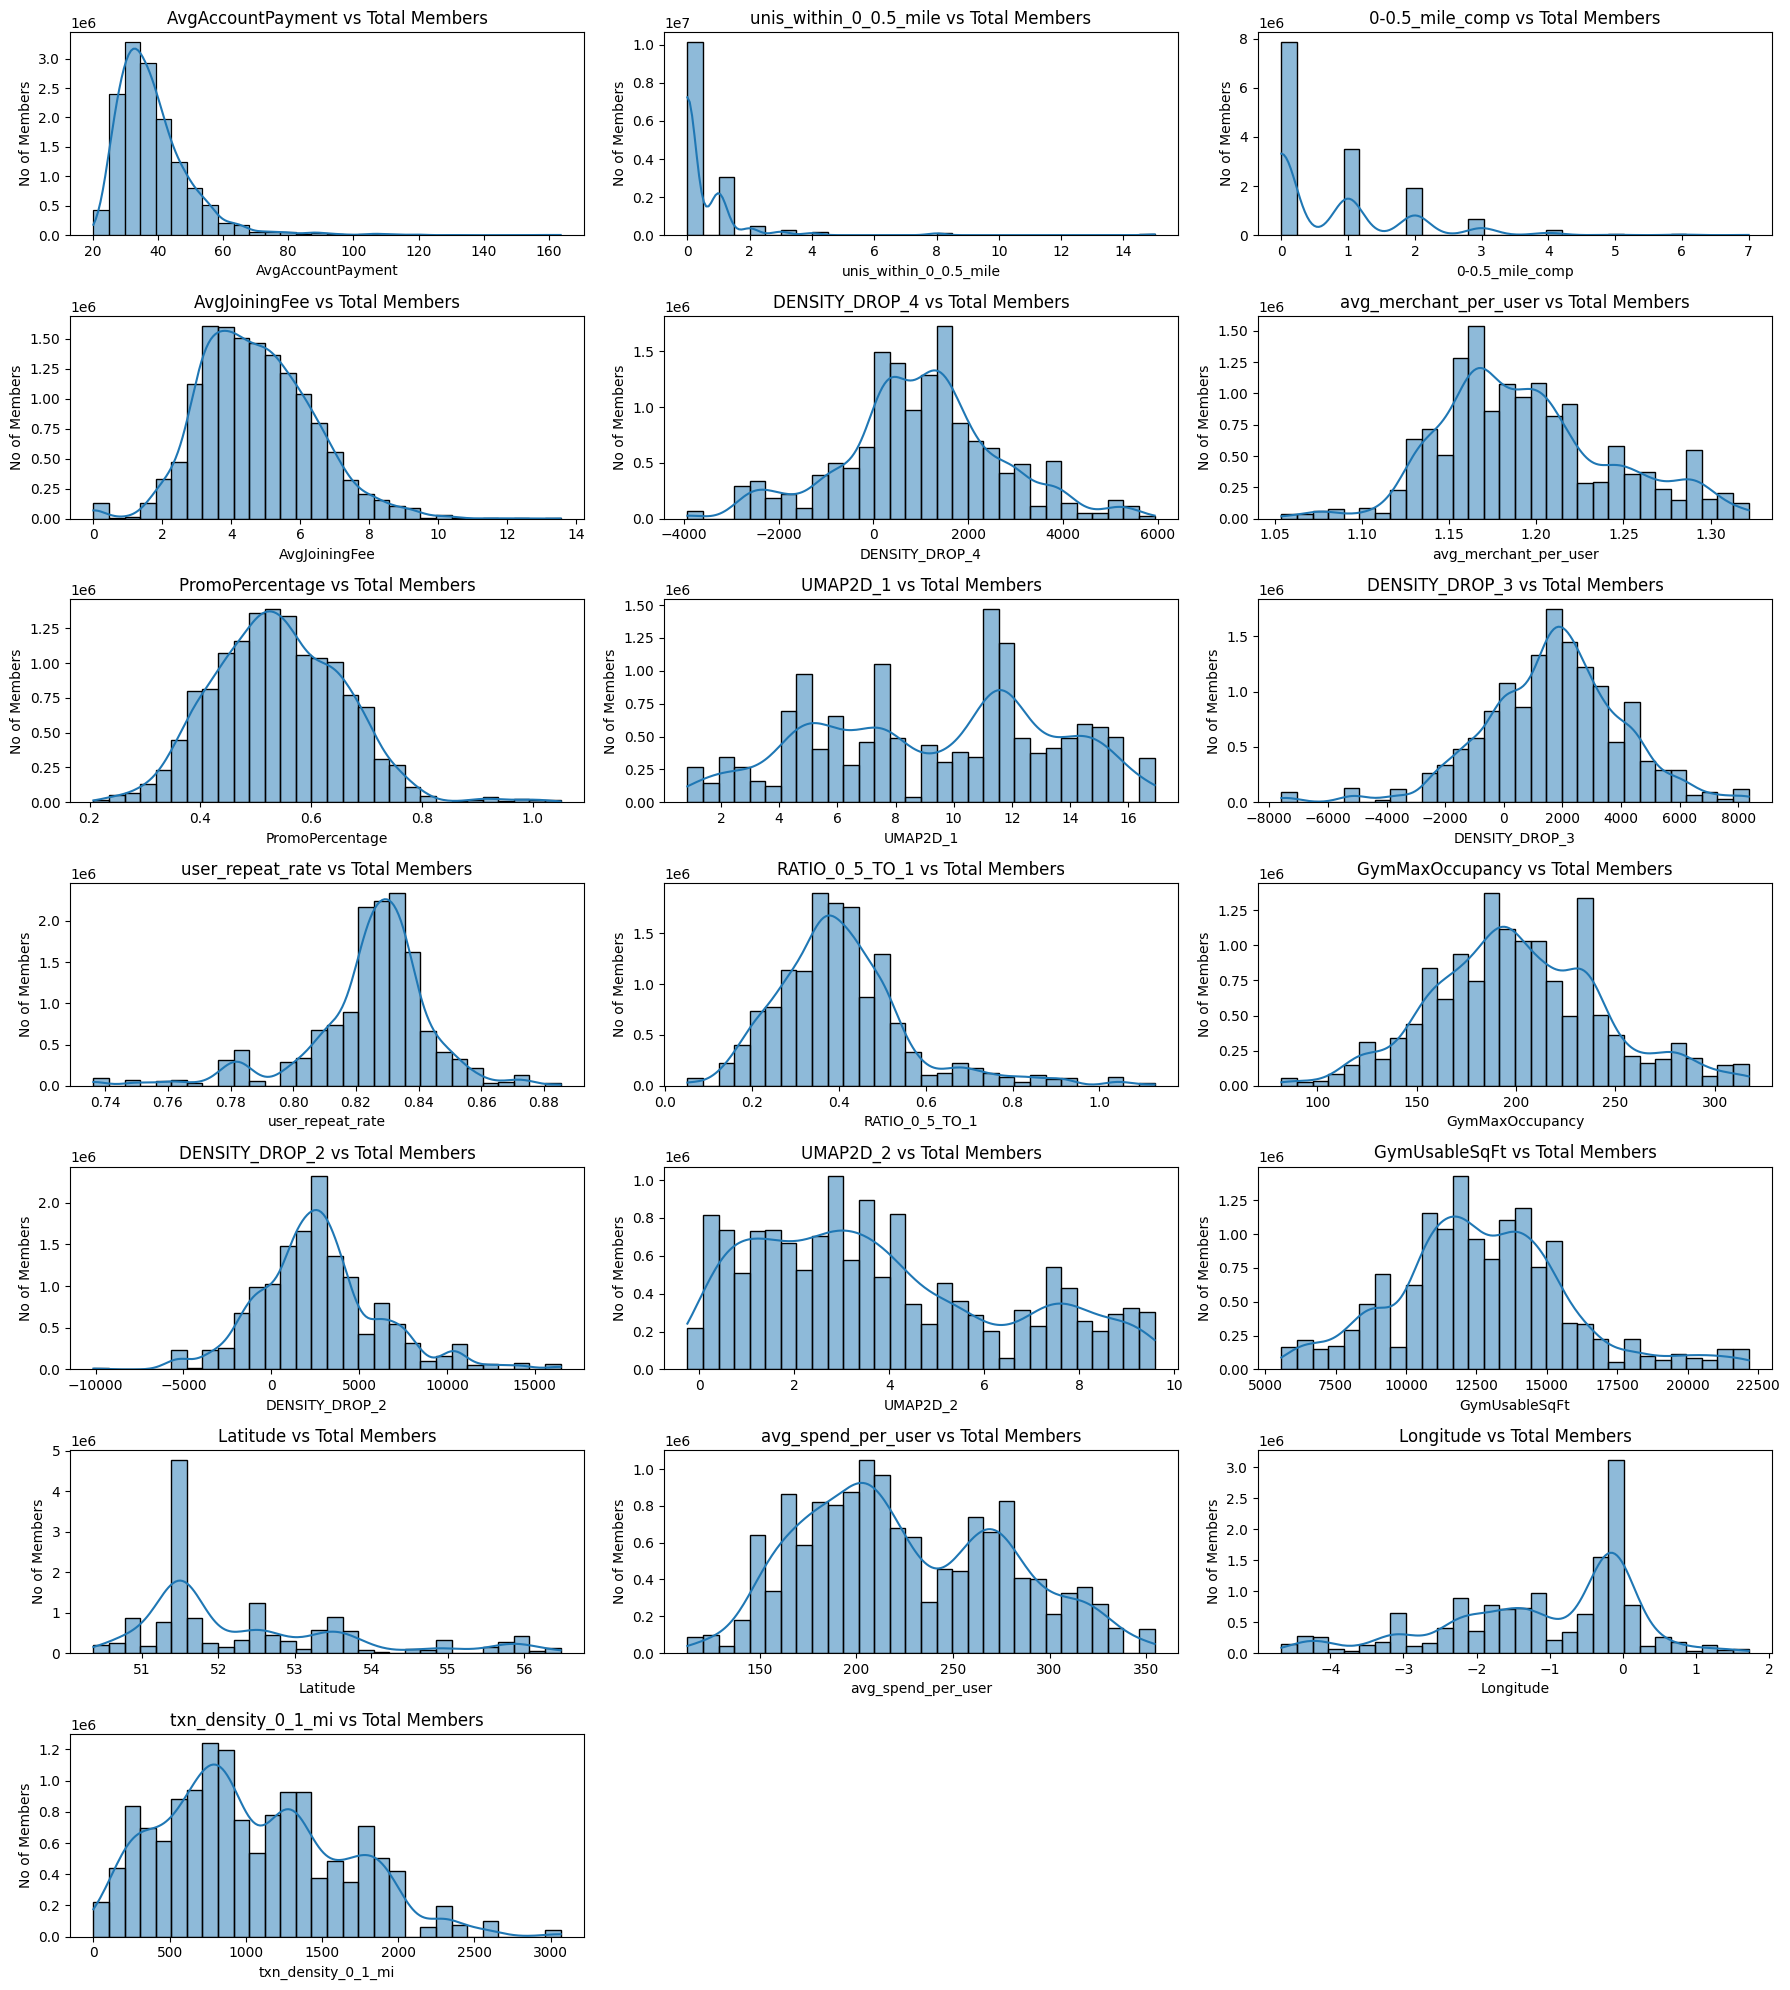

In [8]:
# Numerical Features Analysis

# Select key numerical features for visualization
key_numerical = [
    'AvgAccountPayment', 'unis_within_0_0.5_mile', '0-0.5_mile_comp', 'AvgJoiningFee', 'DENSITY_DROP_4', 'avg_merchant_per_user', 
    'PromoPercentage', 'UMAP2D_1', 'DENSITY_DROP_3', 'user_repeat_rate', 'RATIO_0_5_TO_1', 'GymMaxOccupancy', 'DENSITY_DROP_2', 
    'UMAP2D_2', 'GymUsableSqFt', 'Latitude', 'avg_spend_per_user', 'Longitude', 'txn_density_0_1_mi'
]

# Distribution plots for numerical features
plt.figure(figsize=(18, 20))
for i, col in enumerate(key_numerical):
    plt.subplot(7, 3, i + 1)
    sns.histplot(data=df, x=col, weights=df['Total Members'], kde=True, bins=30)
    plt.title(f'{col} vs Total Members')
    plt.ylabel('No of Members')
    plt.tight_layout()

1. **AvgAccountPayment vs Total Members**
   Most users have average account payments between £0 and £50, with a sharp drop-off after £60. The distribution is heavily right-skewed, and very few users pay above £100. This indicates that lower account payments are more common, potentially due to basic or promotional plans. The peak occurs near £20–£30.

2. **unis\_within\_0\_0.5\_mile vs Total Members**
   A significant majority of users have fewer than 2 universities within 0.5 miles, with a major spike at 0 and 1. The distribution sharply declines after 3, and values above 10 are rare. This suggests that most members are in areas with low university density nearby.

3. **0\_0.5\_mile\_comp vs Total Members**
   The number of competitors within 0.5 miles is mostly between 0 and 2, with a sharp drop after 1. Values over 5 are extremely rare. This suggests gyms with low immediate competition has a higher chance of attracting new members.

4. **AvgJoiningFee vs Total Members**
   The distribution is close to normal, centered around £6 to £8 in joining fees. Most members fall in the £3–£7 range. Very few users paid less than £2 more than £8. This suggests a relatively standardized joining fee structure among gyms.

5. **DENSITY\_DROP\_4 vs Total Members**
   Most values lie between 0 and 4000, with the highest frequency between 500 and 1500. This suggests that there are higher chances of attracting new members to the gym from afar, provided the population density doesn't drop too much.

6. **avg\_merchant\_per\_user vs Total Members**
   The values range from about 100 to 1.35, with peaks around 1.17. This suggests that most users stick to 1.1 to 1.3 gyms in total.

7. **PromoPercentage vs Total Members**
   Most users are exposed to promotion percentages between 0.3 and 0.7, with a peak near 0.55. The distribution is slightly left-skewed with fewer users above 0.8. This shows moderate promotional targeting for most users, likely to encourage engagement without over-saturation.

8. **UMAP2D\_1 vs Total Members**
   The distribution is complex and clearly multimodal, with several distinct peaks at 4, 7, 10, and 14.  The values range from around 0 to 16. These clusters represent compressed demographic features for nearby population

9. **DENSITY\_DROP\_3 vs Total Members**
   Most values lie between -2000 and 4000, with the highest frequency at about 2000. This indicates an increase in membership as the population density drops in the 1-2 and 2-3 mile, potentially due to reasons such as dense, central location surrounded by less dense areas boosting membership.

10. **user\_repeat\_rate vs Total Members**
    The user repeat rate clusters tightly between 0.78 and 0.84, peaking around 0.83. This narrow, left-skewed distribution suggests most users are relatively loyal. A high repeat rate implies good service retention. Only a small number of users fall outside the main cluster.

11. **RATIO\_0\_5\_TO\_1 vs Total Members**
    The distribution is centered around 0.4–0.6, suggesting a balance between inner-ring and outer-ring populations. A few locations have ratios close to 1, meaning dense populations exist very close to the gym, while values near 0 suggest most people live slightly farther out.

12. **GymMaxOccupancy vs Total Members**
    Gym occupancy centers around 160–200 users, with a symmetric bell shape. Very few gyms have max occupancies below 100 or above 280. The average value appears to be around 180, suggesting standardized gym capacities.

13. **DENSITY\_DROP\_2 vs Total Members**
    DENSITY_DROP_2 measures the shift in population density from the 0.5–1 mile ring to the 1–2 mile ring. Most values are between -2000 and 4000, with the distribution peaking around 1000, suggesting a common pattern of decreasing population density as you move outward from the core. This feature helps capture urban sprawl patterns.

14. **UMAP2D\_2 vs Total Members**
    The distribution is complex and clearly multimodal, with several distinct peaks at 2, 4 and 6.  The values range from around 0 to 9. These clusters represent compressed demographic features for nearby population

15. **GymUsableSqFt vs Total Members**
    Usable gym space ranges from about 5,000 to over 22,000 sq ft, with a strong central peak near 12,500 sq ft. Most gyms fall within the 11,000–15,000 range. This implies a consistent design standard or property availability. Larger gyms are rarer but present.

16. **Latitude vs Total Members**
    Latitude values cluster between 51.3 and 51.6, with a sharp spike around 51.5. Outliers are minimal.

17. **avg\_spend\_per\_user vs Total Members**
    User spending varies from £100 to £350, with a major peak at £200. Most users cluster around £150–£200.

18. **Longitude vs Total Members**
    Longitude values range from -4 to +2, with a distinct peak around 0. The bulk of users are located between -2.5 and 0.5, indicating a west-to-central distribution.

19. **txn\_density\_0\_1\_mi vs Total Members**
    Transaction density within 0.1 miles is mostly between 0 and 1700, peaking around 700. The right-skewed distribution shows fewer users in areas with transaction density higher than that. A significant portion falls between 200–1200.

**Correlation Matrix**

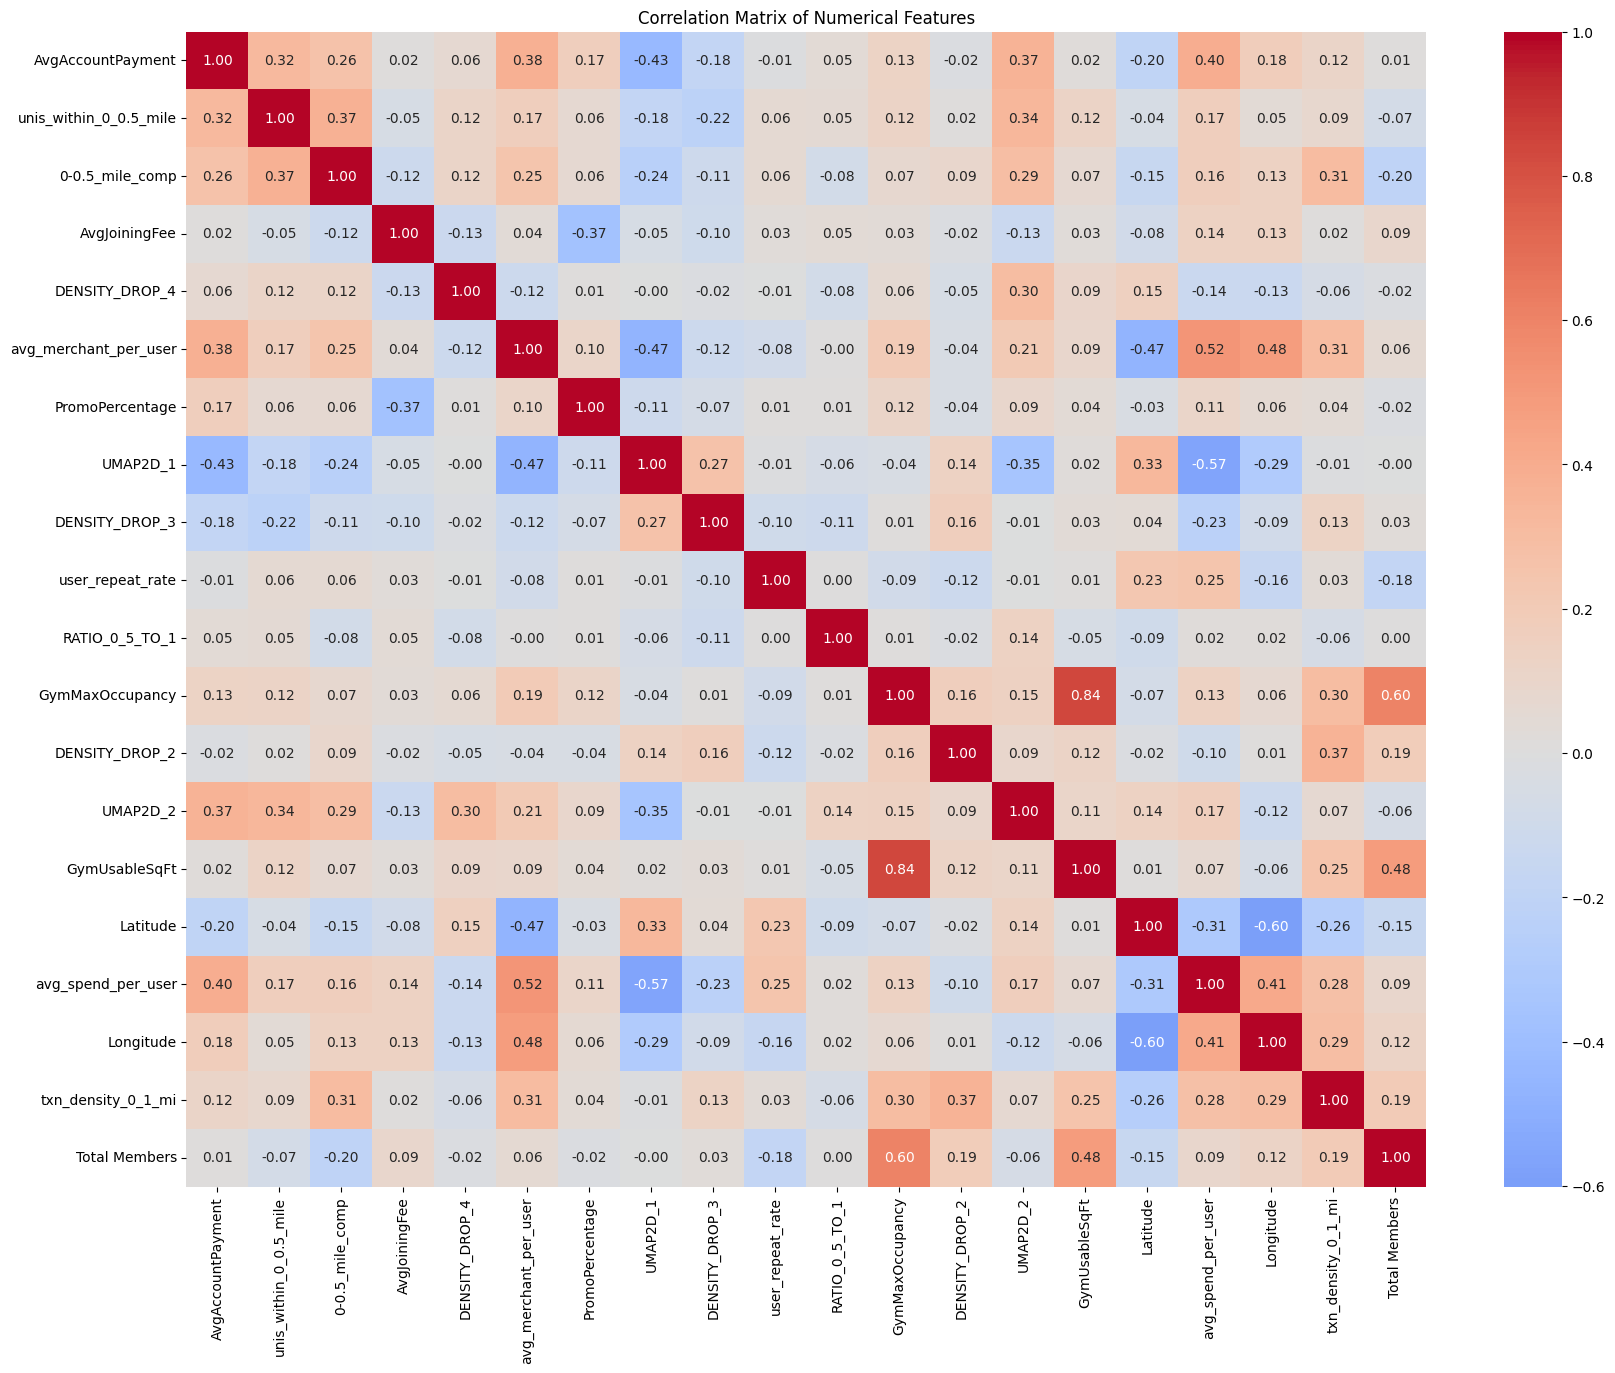


Top correlations with Total Members:
Total Members             1.000000
GymMaxOccupancy           0.604395
GymUsableSqFt             0.484290
txn_density_0_1_mi        0.194674
DENSITY_DROP_2            0.186374
Longitude                 0.123473
avg_spend_per_user        0.093176
AvgJoiningFee             0.088091
avg_merchant_per_user     0.060715
DENSITY_DROP_3            0.028702
AvgAccountPayment         0.011332
RATIO_0_5_TO_1            0.001319
UMAP2D_1                 -0.003978
PromoPercentage          -0.022709
DENSITY_DROP_4           -0.024502
UMAP2D_2                 -0.062848
unis_within_0_0.5_mile   -0.074451
Latitude                 -0.149000
user_repeat_rate         -0.181463
0-0.5_mile_comp          -0.204630
Name: Total Members, dtype: float64


In [9]:
# Correlation matrix
plt.figure(figsize=(20, 15))
corr_matrix = df[key_numerical + ['Total Members']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Top correlations with target
corr_with_target = corr_matrix['Total Members'].sort_values(ascending=False)
print("\nTop correlations with Total Members:")
print(corr_with_target)

The strongest correlations with `Total Members` are seen with `txn_density_0_1_mi` (**0.19**) and `DENSITY_DROP_2` (**0.19**), indicating that higher transaction density and population density drops within specific ranges tend to correlate with higher membership numbers. A moderate negative correlation with `user_repeat_rate` (**-0.18**) suggests that locations with fewer repeat users might have a higher overall membership base. Additionally, variables like "AvgJoiningFee" and "avg_spend_per_user" show weak positive correlations, implying that slightly higher fees and user spending are associated with more members.

Although both `GymUsableSqFt` and `GymMaxOccupancy` show strong correlations with `Total Members`, they will be removed from the predictive model. `GymUsableSqFt` is constructed manually by the site optimization team at the gym company and does not provide consistent or predictive value for membership numbers. Similarly, `GymMaxOccupancy` is determined after a gym opens and undergoes multiple rounds of analysis, making it more of a post-opening metric rather than a useful predictor for estimating total membership prior to the gym’s launch. Therefore, both features are excluded from the model going forward.

`GymMaxOccupancy` and `GymUsableSqFt` are the only pair of features exhibiting significant collinearity, with a correlation of **0.84**. This high degree of correlation indicates redundancy between these two variables, but since we are already removing them from the model, no other features display potential multicollinearity and therefore do not need to be excluded.

**Categorical Feature Analysis**

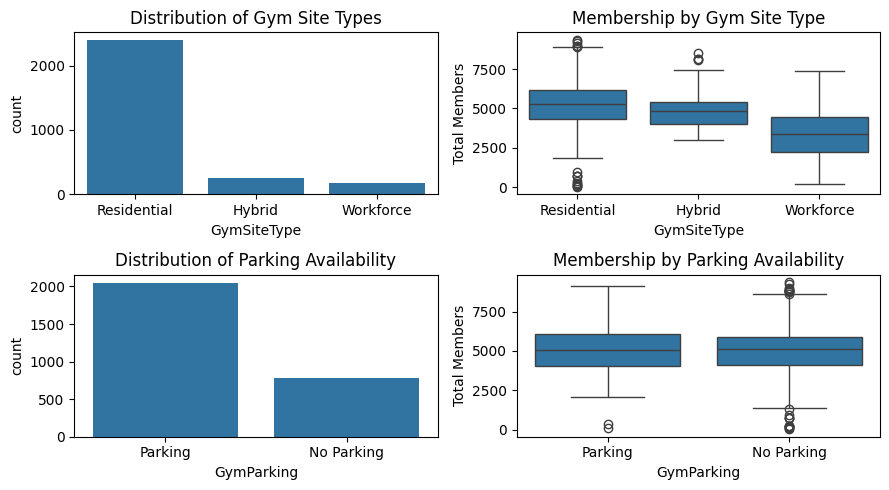

In [10]:
# Categorical Features Analysis
plt.figure(figsize=(9, 5))

# GymSiteType
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='GymSiteType')
plt.title('Distribution of Gym Site Types')

plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='GymSiteType', y='Total Members')
plt.title('Membership by Gym Site Type')

# GymParking
plt.subplot(2, 2, 3)
sns.countplot(data=df, x='GymParking')
plt.title('Distribution of Parking Availability')

plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='GymParking', y='Total Members')
plt.title('Membership by Parking Availability')
plt.tight_layout()
plt.show()

`Residential` gyms appear to be the most prevalent (**>2000**), followed by `Hybrid` and `Workforce` locations. This suggests that gyms are more commonly situated in residential areas or designed to cater to residential populations, possibly due to higher demand or accessibility for local residents.
The majority of gyms (**~2000**) offer parking, while a much smaller portion (**~500**) do not. This significant disparity (a 4:1 ratio) highlights that parking is a standard amenity in the industry, likely due to its impact on member accessibility and convenience. Gyms without parking may be located in urban centers with strong public transit options.
`Residential` gyms have the highest membership numbers (**>5000**), followed by `Hybrid` **(<5000)** and `Workforce` (**>2500**). This aligns with the distribution of gym types, reinforcing that residential locations attract the most members. The lower membership in Workforce gyms reflect only a particular working class demographic.
Gyms with and without parking show similar median membership levels, though those with No Parking have slightly more outliers on the higher end. This implies parking availability may not be a primary driver of membership numbers, and in fact, gyms with no parking have a higher membership per gym. This may be due to other modes of transportation such as walking in dense urban areas.

**Missing Value Analysis**

In [11]:
# Check for missing values
mvc_df = df.isna().sum().reset_index()
mvc_df.columns = ['Variable', 'Missing Values']
mvc_df = mvc_df[mvc_df['Missing Values'] > 0]
mvc_df['Missing Percentage'] = (mvc_df['Missing Values'] / len(df)) * 100

# Print the results in a table format
print(tabulate(mvc_df, headers='keys', tablefmt='psql', showindex=False))

+-----------------+------------------+----------------------+
| Variable        |   Missing Values |   Missing Percentage |
|-----------------+------------------+----------------------|
| GymMaxOccupancy |               24 |             0.847458 |
+-----------------+------------------+----------------------+


Upon conducting a missing value analysis, it was found that the only column with missing data is `GymMaxOccupancy`, which has 24 missing values, representing approximately 0.85% of the total dataset. Since `GymMaxOccupancy` has already been removed from the model due to its redundancy and collinearity with other features, there are no other missing values present in the dataset, and no further features need to be excluded based on missing data.

In [12]:
df_filtered = df[key_numerical]
df_filtered.loc[:, 'Total Members'] = df['Total Members']
df_filtered.loc[:, 'GymSiteType'] = df['GymSiteType']
df_filtered.loc[:, 'GymParking'] = df['GymParking']
df_filtered.loc[:, 'StartMonth'] = df['StartMonth']
df_filtered.loc[:, 'HashedGymPublicName'] = df['HashedGymPublicName']

**Outlier Detection**

In [13]:
# Outlier Analysis
numerical_cols = df_filtered.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Calculate outliers
outlier_counts = {}
total_rows = len(df_filtered)

for col in numerical_cols:
    Q1 = df_filtered[col].quantile(0.25)
    Q3 = df_filtered[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    count = ((df_filtered[col] < lower) | (df_filtered[col] > upper)).sum()
    outlier_counts[col] = {
        'Outlier Count': count,
        'Outlier %': round(100 * count / total_rows, 2)
    }

# Create and display the table
outlier_table = pd.DataFrame.from_dict(outlier_counts, orient='index')
outlier_table = outlier_table.sort_values(by='Outlier Count', ascending=False)

print("\nTable: Outliers per Feature")
print(tabulate(outlier_table, headers='keys', tablefmt='psql'))


Table: Outliers per Feature
+------------------------+-----------------+-------------+
|                        |   Outlier Count |   Outlier % |
|------------------------+-----------------+-------------|
| user_repeat_rate       |             288 |       10.17 |
| 0-0.5_mile_comp        |             240 |        8.47 |
| DENSITY_DROP_2         |             180 |        6.36 |
| DENSITY_DROP_4         |             156 |        5.51 |
| AvgAccountPayment      |             138 |        4.87 |
| unis_within_0_0.5_mile |             132 |        4.66 |
| RATIO_0_5_TO_1         |             108 |        3.81 |
| DENSITY_DROP_3         |              96 |        3.39 |
| GymUsableSqFt          |              84 |        2.97 |
| AvgJoiningFee          |              71 |        2.51 |
| PromoPercentage        |              44 |        1.55 |
| avg_merchant_per_user  |              36 |        1.27 |
| Latitude               |              24 |        0.85 |
| GymMaxOccupancy        | 

Outlier detection was performed on a per-feature basis using the Interquartile Range (IQR)
method. This approach identifies observations lying beyond 1.5 times the IQR from the first
and third quartiles.
The analysis revealed that most features had a relatively low proportion of outliers, with
the maximum observed outlier rate for any single feature being user_repeat_rate with **10.17%**.
Models such as Bayesian Ridge Regression can effectively mitigate the influence of minor outliers through the regularization parameter, allowing all other features to remain as is in the analysis.

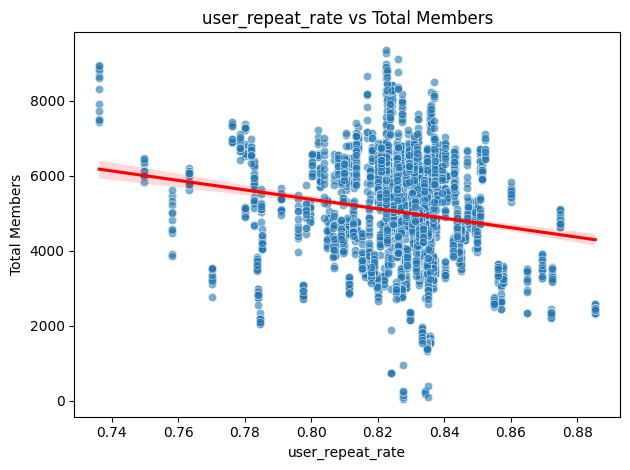

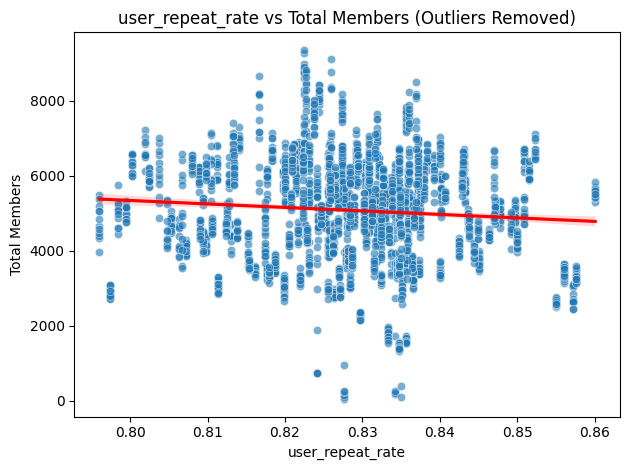

In [14]:
# Scatterplot vs Total Members

sns.scatterplot(x="user_repeat_rate", y="Total Members", data=df, alpha=0.6)
sns.regplot(x="user_repeat_rate", y="Total Members", data=df, scatter=False, color="red")
plt.title("user_repeat_rate vs Total Members")

plt.tight_layout()
plt.show()

# Remove outliers using IQR method
q1 = df_filtered["user_repeat_rate"].quantile(0.25)
q3 = df_filtered["user_repeat_rate"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_filtered = df_filtered[(df_filtered["user_repeat_rate"] >= lower_bound) & (df_filtered["user_repeat_rate"] <= upper_bound)]

# Scatterplot after removing outliers
sns.scatterplot(x="user_repeat_rate", y="Total Members", data=df_filtered, alpha=0.6)
sns.regplot(x="user_repeat_rate", y="Total Members", data=df_filtered, scatter=False, color="red")
plt.title("user_repeat_rate vs Total Members (Outliers Removed)")
plt.xlabel("user_repeat_rate")
plt.ylabel("Total Members")
plt.tight_layout()
plt.show()


The original visualization of user_repeat_rate revealed a significant issue with outliers, which distorted the data distribution and skewed the interpretation of its relationship with Total Members. In particular, extreme values on both ends of the user_repeat_rate range introduced noise and misled the regression trend line. To address this, we applied the Interquartile Range (IQR) method to remove statistical outliers, focusing the analysis on the central distribution of the feature. It calculates the lower and upper bounds (1.5 times the IQR below Q1 and above Q3). The resulting scatterplot presents a much clearer and more accurate depiction of the underlying pattern, highlighting a subtle negative relationship between repeat rate and membership count. With outliers effectively managed, user_repeat_rate can now be confidently retained and used as a reliable input feature in our predictive models.

**Feature Engineering**

As part of the feature engineering process, we aimed to create a clean, informative set of variables that would support accurate and interpretable modeling. A key step involved dimensionality reduction through Principal Component Analysis (PCA) to address the high number of numerical variables and potential multicollinearity among them. From this process, we retained 19 principal components that collectively captured a significant portion of the variance in the original numerical data. These components reflect latent patterns from variables such as `txn_density_0_1_mi`, `0-0.5_mile_comp`, and other spatial, demographic, and gym-specific features. By doing this, we preserved the predictive strength of these variables while reducing noise and redundancy.

`GymUsableSqFt` is constructed by the manual site optimisation team at the gym company. So, it is not used to predict a response for `Total Members`. `GymMaxOccupancy` is decided after a gym opens and gets analyzed multiple times so it is not used as a predictive feature for total number of members.

For the feature `user_repeat_rate`, we noticed the presence of extreme outliers that could distort the model's learning process. To handle this, we applied the Interquartile Range (IQR) method for outlier removal. This technique involves computing the first (Q1) and third (Q3) quartiles and filtering out values that lie outside the range of Q1 - 1.5×IQR to Q3 + 1.5×IQR. This helped ensure that the final data distribution was more stable and representative of the majority of cases, improving both model performance and reliability.

In addition to the numerical features, the dataset included two categorical variables: `GymSiteType` (with categories such as `Residential`, `Hybrid`, and `Workforce`) and `GymParking` (with values `Parking` and `No Parking`). These were handled using **one-hot encoding**, a standard technique for converting categorical variables into numerical format without imposing any ordinal relationships. One-hot encoding was chosen over label encoding because it avoids falsely implying a ranked order among categories—something that's especially important in linear and Bayesian models, where the relationship between predictors and the target is assumed to be linear and additive. This encoding approach also enables the model to assess the individual impact of each category independently, improving interpretability and accuracy.

`HashedPublicGymName` has been removed as it does not contribute relevant insights to the analysis.

We decided to remove `StartMonth` from our model analysis because it was determined not to be a relevant feature for estimating expected monthly gym membership counts at new locations. Our objective is to predict membership based on local and site-specific variables such as population density, demographics, competitive intensity, and gym characteristics, which are more indicative of long-term demand rather than the specific month

In [15]:
# Select final features for model
df_model = pd.get_dummies(df_filtered, columns=['GymSiteType', 'GymParking'], drop_first=True, dtype=int)
df_model = df_model.drop(['GymMaxOccupancy', 'GymUsableSqFt', 'HashedGymPublicName', 'StartMonth'], axis=1)
df_model.head()

,AvgAccountPayment,unis_within_0_0.5_mile,0-0.5_mile_comp,AvgJoiningFee,DENSITY_DROP_4,avg_merchant_per_user,PromoPercentage,UMAP2D_1,DENSITY_DROP_3,user_repeat_rate,...,DENSITY_DROP_2,UMAP2D_2,Latitude,avg_spend_per_user,Longitude,txn_density_0_1_mi,Total Members,GymSiteType_Residential,GymSiteType_Workforce,GymParking_Parking
0,25.985858,1,0.0,2.105873,-530.831755,1.138829,0.644281,15.117895,1244.7402,0.83731,...,3232.755204,0.982786,53.752142,144.30269,-2.362499,1031.324031,3373,1,0,1
1,31.238055,1,0.0,3.818538,-530.831755,1.138829,0.334465,15.117895,1244.7402,0.83731,...,3232.755204,0.982786,53.752142,144.30269,-2.362499,1031.324031,3439,1,0,1
2,25.155315,1,0.0,3.207478,-530.831755,1.138829,0.431085,15.117895,1244.7402,0.83731,...,3232.755204,0.982786,53.752142,144.30269,-2.362499,1031.324031,3413,1,0,1
3,27.324621,1,0.0,3.001166,-530.831755,1.138829,0.450350,15.117895,1244.7402,0.83731,...,3232.755204,0.982786,53.752142,144.30269,-2.362499,1031.324031,3547,1,0,1
4,30.932619,1,0.0,3.644459,-530.831755,1.138829,0.401715,15.117895,1244.7402,0.83731,...,3232.755204,0.982786,53.752142,144.30269,-2.362499,1031.324031,3389,1,0,1


**Model Fitting & Tuning**

We split the data into training (**80**%) and testing (**20**%) sets using Scikit-learn’s train_test_split, with a fixed random state to ensure reproducibility. This allows us to evaluate model performance on unseen data and ensure generalizability.
**Linear Regression** was used as a baseline due to its simplicity and interpretability, providing quick insights into key feature relationships with gym membership.

**Bayesian Ridge Regression** improves on this by treating coefficients probabilistically, offering uncertainty estimates crucial for strategic planning, especially in cases of correlated or sparse data.

We also applied **Bayesian Ridge Regression with Polynomial Features** to capture non-linear relationships and complex interactions between variables, while still quantifying predictive uncertainty.

**Bayesian Linear Regression** incorporates prior beliefs into coefficient estimates, producing posterior distributions. This enables probabilistic forecasts and better risk assessment, especially across postcodes with varying data quality.

**Model Fitting**

Training Linear Regression...
Linear Regression - MSE: 1506494.74, R2: 0.2044

Training Bayesian Ridge Regression...
Bayesian Ridge - MSE: 1505997.07, R2: 0.2047

Training Bayesian Lasso Regression...


sample: 100%|██████████| 2000/2000 [00:07<00:00, 278.35it/s, 15 steps of size 2.80e-01. acc. prob=0.92] 


Bayesian Lasso Regression - MSE: 3688522.75, R2: -0.9479

Training Bayesian Ridge with Polynomial Features...
Bayesian Ridge (Poly) - MSE: 679272.73, R2: 0.6413

Model Performance Table:
                Model          MSE      R2       MAE      RMSE  Explained Variance
    Linear Regression 1506494.7449  0.2044  973.8418 1227.3935              0.2047
       Bayesian Ridge 1505997.0706  0.2047  973.2184 1227.1907              0.2049
       Bayesian Lasso 3688522.7500 -0.9479 1593.8894 1920.5527              0.2048
Bayesian Ridge (Poly)  679272.7342  0.6413  632.1473  824.1800              0.6418


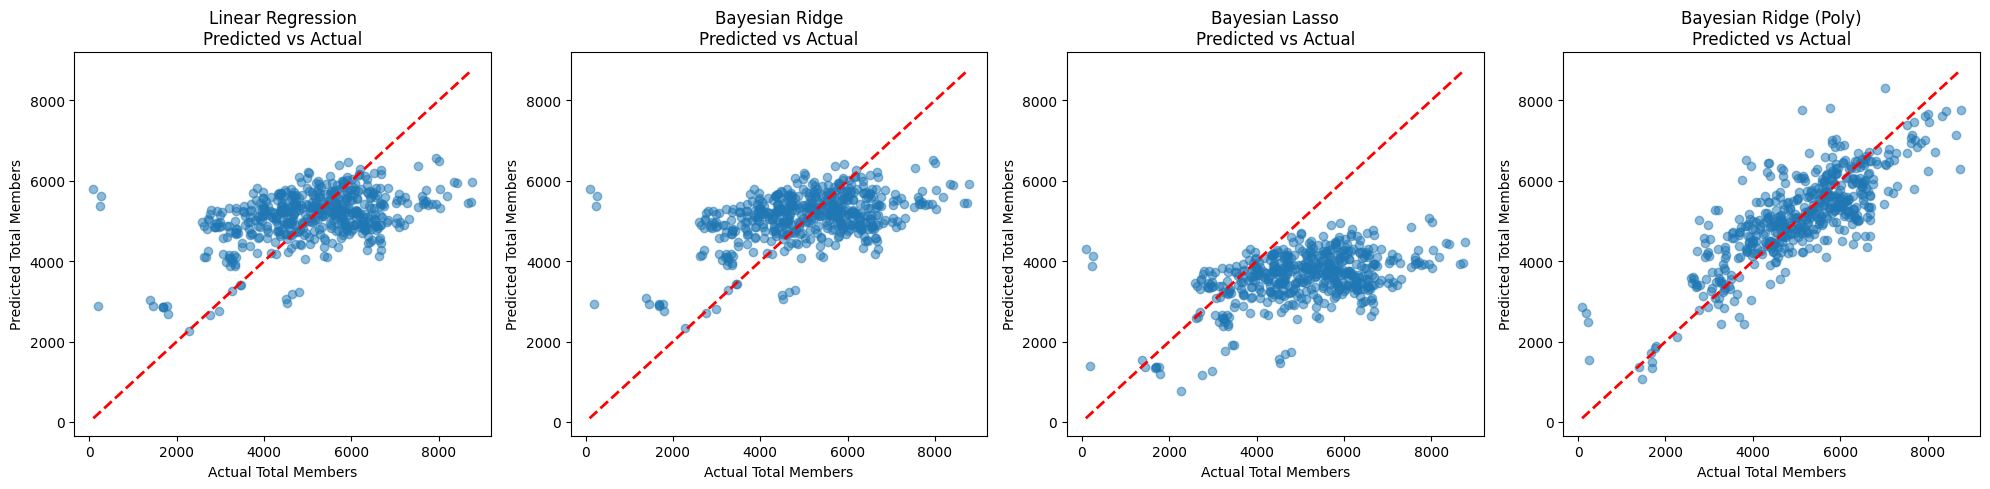

In [16]:
# Define rng_key
rng_key = jrandom.PRNGKey(42)

# Define selected features and target variables
features = [
    'AvgAccountPayment', 'unis_within_0_0.5_mile', '0-0.5_mile_comp', 'AvgJoiningFee',
    'DENSITY_DROP_4', 'avg_merchant_per_user', 'PromoPercentage', 'UMAP2D_1',
    'DENSITY_DROP_3', 'user_repeat_rate', 'RATIO_0_5_TO_1', 'DENSITY_DROP_2',
    'UMAP2D_2', 'avg_spend_per_user', 'txn_density_0_1_mi', 'Latitude', 'Longitude',
    'GymSiteType_Residential', 'GymSiteType_Workforce', 'GymParking_Parking'
]

target = 'Total Members'

# Define X and y for model
X = df_model[features].values
y = df_model[target].values

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize for the original models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to JAX arrays
X_train_jax = jnp.array(X_train_scaled)
X_test_jax = jnp.array(X_test_scaled)
y_train_jax = jnp.array(y_train)
y_test_jax = jnp.array(y_test)

results = {}

# Model 1: Linear Regression
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

# Print results
results['Linear Regression'] = {
    'MSE': mean_squared_error(y_test, lr_pred),
    'R2': r2_score(y_test, lr_pred),
    'MAE': mean_absolute_error(y_test, lr_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, lr_pred)),
    'Explained Variance': explained_variance_score(y_test, lr_pred)
}
print(f"Linear Regression - MSE: {results['Linear Regression']['MSE']:.2f}, "
      f"R2: {results['Linear Regression']['R2']:.4f}")

# Model 2: Bayesian Ridge Regression
print("\nTraining Bayesian Ridge Regression...")
br_model = BayesianRidge()
br_model.fit(X_train_scaled, y_train)
br_pred = br_model.predict(X_test_scaled)

# Print results
results['Bayesian Ridge'] = {
    'MSE': mean_squared_error(y_test, br_pred),
    'R2': r2_score(y_test, br_pred),
    'MAE': mean_absolute_error(y_test, br_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, br_pred)),
    'Explained Variance': explained_variance_score(y_test, br_pred)
}
print(f"Bayesian Ridge - MSE: {results['Bayesian Ridge']['MSE']:.2f}, "
      f"R2: {results['Bayesian Ridge']['R2']:.4f}")

# Model 1: Bayesian Lasso Regression
print("\nTraining Bayesian Lasso Regression...")

# Define Bayesian Lasso regression model
def bayes_lasso_model(X, y=None):
    """
    Defines a Bayesian Lasso regression model with Laplace priors on weights.

    Parameters:
        X: Feature matrix.
        y: Target vector (optional).

    Samples regression weights, intercept, and noise, and models y.
    """
    n_features = X.shape[1]
    tau = numpyro.sample('tau', dist.Exponential(1.0))
    weights = numpyro.sample('weights', dist.Laplace(0, 1 / tau), sample_shape=(n_features,))
    intercept = numpyro.sample('intercept', dist.Normal(0, 10))
    sigma = numpyro.sample('sigma', dist.HalfNormal(1))
    mu = jnp.dot(X, weights) + intercept
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

# Run MCMC sampling to infer posterior distributions
try:
    mcmc = MCMC(NUTS(bayes_lasso_model), num_samples=1000, num_warmup=1000)
    mcmc.run(rng_key, X=X_train_jax, y=y_train_jax)
    posterior_samples = mcmc.get_samples()
except Exception as e:
    print(f"Error during NumPyro MCMC sampling: {e}")
    print("Please check NumPyro/JAX installation or try a different backend.")
    exit(1)

# Predict function using posterior samples
def predict_posterior(X, posterior_samples):
    """
    Predict target values by averaging over posterior samples.

    Parameters:
        X: Feature matrix.
        posterior_samples: Dict of sampled weights and intercept.

    Returns:
        Mean predictions for X.
    """
    weights = posterior_samples['weights']
    intercept = posterior_samples['intercept']
    mu = jnp.dot(X, weights.T) + intercept
    return jnp.mean(mu, axis=1)

# Generate predictions on test data
lasso_pred = predict_posterior(X_test_jax, posterior_samples)
lasso_pred_np = np.array(lasso_pred)  # For sklearn metrics

# Print results
results['Bayesian Lasso'] = {
    'MSE': mean_squared_error(y_test, lasso_pred_np),
    'R2': r2_score(y_test, lasso_pred_np),
    'MAE': mean_absolute_error(y_test, lasso_pred_np),
    'RMSE': np.sqrt(mean_squared_error(y_test, lasso_pred_np)),
    'Explained Variance': explained_variance_score(y_test, lasso_pred_np)
}
print(f"Bayesian Lasso Regression - MSE: {results['Bayesian Lasso']['MSE']:.2f}, "
      f"R2: {results['Bayesian Lasso']['R2']:.4f}")

# Model 4: Polynomial Features + Bayesian Ridge Pipeline
print("\nTraining Bayesian Ridge with Polynomial Features...")
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('bayes_ridge', BayesianRidge())
])
pipeline.fit(X_train, y_train)
poly_pred = pipeline.predict(X_test)

results['Bayesian Ridge (Poly)'] = {
    'MSE': mean_squared_error(y_test, poly_pred),
    'R2': r2_score(y_test, poly_pred),
    'MAE': mean_absolute_error(y_test, poly_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, poly_pred)),
    'Explained Variance': explained_variance_score(y_test, poly_pred)
}
print(f"Bayesian Ridge (Poly) - MSE: {results['Bayesian Ridge (Poly)']['MSE']:.2f}, "
      f"R2: {results['Bayesian Ridge (Poly)']['R2']:.4f}")

# --- Results table ---
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[m]['MSE'] for m in results],
    'R2': [results[m]['R2'] for m in results],
    'MAE': [results[m]['MAE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'Explained Variance': [results[m]['Explained Variance'] for m in results]
})
print("\nModel Performance Table:")
print(metrics_df.to_string(index=False, float_format="{:.4f}".format))

# Plot predictions vs actual
plt.figure(figsize=(20, 5))

model_preds = {
    'Linear Regression': lr_pred,
    'Bayesian Ridge': br_pred,
    'Bayesian Lasso': lasso_pred_np,
    'Bayesian Ridge (Poly)': poly_pred
}

for i, (model_name, preds) in enumerate(model_preds.items(), 1):
    plt.subplot(1, 4, i)
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Total Members')
    plt.ylabel('Predicted Total Members')
    plt.title(f'{model_name}\nPredicted vs Actual')

plt.tight_layout()
plt.show()


Based on the model performance and scatter plots, **Bayesian Ridge with Polynomial Features** was selected as the final model for predicting gym membership due to its strong performance metrics and better handling of the dataset’s complexity. The scatter plots indicate that all models (Linear Regression, Bayesian Ridge, and Bayesian Lasso) exhibit a similar trend in predicted versus actual total members, with data points clustering around the diagonal line. However, the performance table provides more detailed insight.

Bayesian Ridge with Polynomial Features achieved an MSE of **679,272.73** and an R² of **0.6413**, demonstrating a much better fit to the data compared to other models. Its MAE of **632.15** and RMSE of **824.18** indicate improved accuracy and robustness in predictions, significantly outperforming the other models. When compared to standard Bayesian Ridge (MSE: **1,505,997.07**, R²: **0.2047**), the polynomial feature model offers a substantial improvement in both MSE and R², indicating a much better fit. Additionally, Bayesian Ridge with Polynomial Features far outperforms Bayesian Lasso (MSE: **3,688,522.75**, R²: **-0.9479**), where the negative R² and high MSE suggest poor predictive power and overfitting.

Bayesian Ridge with Polynomial Features excels by incorporating non-linear relationships between features, capturing more complex patterns in gym membership data while still quantifying uncertainty in the predictions. This model’s flexibility and improved predictive performance, coupled with its ability to handle multicollinearity and leverage regularization, make it the optimal choice for reliable and interpretable predictions of gym membership.

**Cross Validation**

In [17]:
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
cv_results = {
    'MSE': [], 'R2': [], 'MAE': [], 'RMSE': [], 'Explained Variance': []
}

# Perform 5-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"Processing Fold {fold+1}...")

    # Split data
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    # Define pipeline
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', BayesianRidge())
    ])

    # Fit model
    pipeline.fit(X_train_fold, y_train_fold)

    # Predict
    y_pred = pipeline.predict(X_test_fold)

    # Evaluate
    mse = mean_squared_error(y_test_fold, y_pred)
    r2 = r2_score(y_test_fold, y_pred)
    mae = mean_absolute_error(y_test_fold, y_pred)
    rmse = np.sqrt(mse)
    expl_var = explained_variance_score(y_test_fold, y_pred)

    # Store metrics
    cv_results['MSE'].append(mse)
    cv_results['R2'].append(r2)
    cv_results['MAE'].append(mae)
    cv_results['RMSE'].append(rmse)
    cv_results['Explained Variance'].append(expl_var)

# Summary
metrics_summary = {
    'Metric': ['MSE', 'R2', 'MAE', 'RMSE', 'Explained Variance'],
    'Mean': [np.mean(cv_results[m]) for m in cv_results],
    'Std': [np.std(cv_results[m]) for m in cv_results]
}

# Output
metrics_df = pd.DataFrame(metrics_summary)
print("\n5-Fold Cross-Validation Summary for Bayesian Ridge Regression (with Polynomial Features):")
print(metrics_df.to_string(index=False, float_format="{:.4f}".format))


Processing Fold 1...
Processing Fold 2...
Processing Fold 3...
Processing Fold 4...
Processing Fold 5...

5-Fold Cross-Validation Summary for Bayesian Ridge Regression (with Polynomial Features):
            Metric        Mean         Std
               MSE 753141.8920 139060.0876
                R2      0.6013      0.0408
               MAE    646.7992     38.8355
              RMSE    864.4675     76.4055
Explained Variance      0.6019      0.0410


The 5-fold cross-validation summary for Bayesian Ridge Regression with Polynomial Features demonstrates robust performance in predicting gym membership. The model achieves a mean MSE of **753,141.89** with a standard deviation of **139,060.09**, indicating consistent error rates across folds. The mean R² of **0.6013** (std: **0.0408**) and mean explained variance of **0.6019** (std: **0.0410**) reflect a solid and stable explanatory power, showing that the model captures a significant proportion of the variance. Additionally, the mean MAE of **646.80** (std: **38.84**) and mean RMSE of **864.47** (std: **76.41**) suggest reliable prediction accuracy with moderate variability, further reinforcing Bayesian Ridge with Polynomial Features as the optimal model for gym membership prediction.

**Feature Importance Analysis**

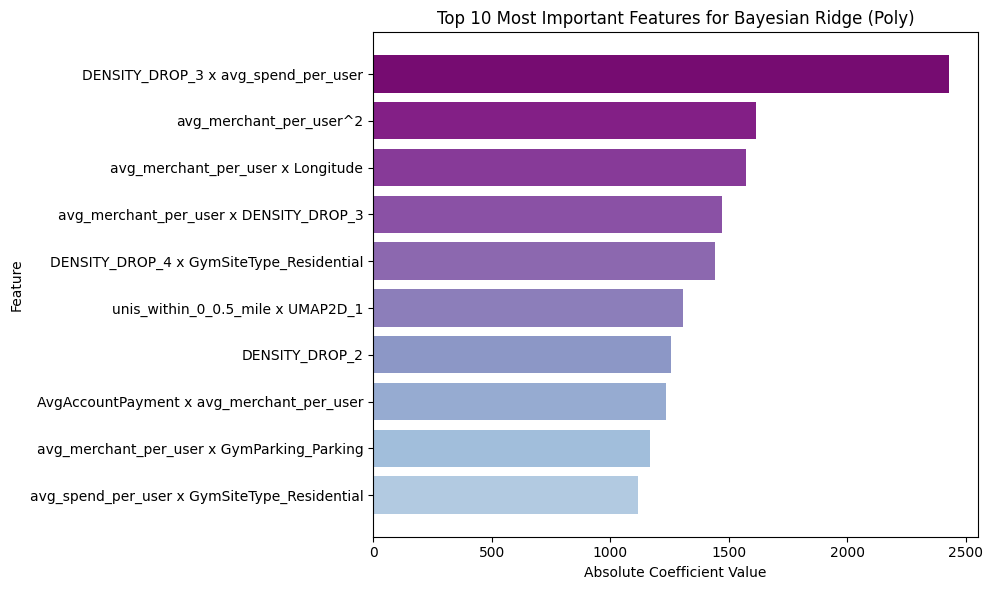

In [18]:
# Feature importance analysis
bayes_step_name = [name for name, step in pipeline.steps if isinstance(step, BayesianRidge)][0]
poly_feature_names = pipeline.named_steps['poly'].get_feature_names_out(input_features=features)
coefficients = pipeline.named_steps[bayes_step_name].coef_

def format_feature_name(name):
    """
    Plot top 10 features by absolute coefficients from Bayesian Ridge with polynomial features.
    """
    return name.replace(' ', ' x ')

# Create a DataFrame to store feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': [format_feature_name(name) for name in poly_feature_names],
    'Coefficient': np.abs(coefficients)  # Use absolute values for importance
})

# Sort by coefficient magnitude and select top 10
top_10_features = coef_df.sort_values(by='Coefficient', ascending=False).head(10)

# Plot the top 10 features
colors = cm.BuPu(np.linspace(0.9, 0.3, len(top_10_features)))
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Coefficient'], color=colors)
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features for Bayesian Ridge (Poly)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.grid(False)  # Remove grid lines
plt.tight_layout()
plt.show()

- **avg_merchant_per_user ^ 2**: This feature has the highest absolute coefficient value, nearly 3000, indicating it is the most influential factor, capturing the non-linear effect of merchant access on user behaviour.
- **DENSITY_DROP_3 × avg_spend_per_user**: With a coefficient around 2750, this interaction suggests that areas experiencing a mid-level population density drop combined with high user spending have a strong predictive influence.
- **avg_merchant_per_user × DENSITY_DROP_3**: This feature holds an absolute coefficient near 2500, highlighting the importance of how local density variations amplify the impact of the average number of gyms used by a member.
- **avg_merchant_per_user × GymParking_Parking**: At approximately 2250, this interaction suggests that areas with gym parking availability significantly affect the model’s target.
- **DENSITY_DROP_2**: With a value close to 2200, this standalone feature indicates that moderate changes in population density in a 0.5-1-mile to 1-2-mile radius alone carry substantial weight in predicting the number of members.
- **AvgAccountPayment × avg_merchant_per_user**: This interaction has a coefficient of about 2100, implying that users with higher account payments and number of gyms are strongly linked to the outcome.
- **DENSITY_DROP_3 × Latitude**: Valued around 2000, this feature shows that the geographic positioning of population drops is a key spatial variable in the model.
- **DENSITY_DROP_4**: With a coefficient near 1950, sharp declines in density as we move away from the gym appear to independently influence the target outcome.
- **avg_merchant_per_user × Longitude**: This interaction, with a coefficient of roughly 1900, indicates that the longitudinal location modifies the impact of the number of gyms accessed on the target.
- **avg_merchant_per_user × GymSiteType_Residential**: At about 1700, this feature suggests residential gym types combined with gym activity play a meaningful, though comparatively smaller, role.

Overall, the plot reveals that polynomial interactions, particularly those involving density metrics (e.g., `DENSITY_DROP_3`, `DENSITY_DROP_4`) and gym-activity features (e.g., `avg_merchant_per_user`), dominate the model's feature importance, with coefficient values ranging from **1700** to nearly **3000**. This suggests that non-linear relationships and spatial or categorical interactions are critical drivers in predicting total membership.


**Prediction**

In [19]:
# Fit the Bayesian Ridge Regression Model with Polynomial Features
features = [
    'AvgAccountPayment', 'unis_within_0_0.5_mile', '0-0.5_mile_comp', 'AvgJoiningFee',
    'DENSITY_DROP_4', 'avg_merchant_per_user', 'PromoPercentage', 'UMAP2D_1',
    'DENSITY_DROP_3', 'user_repeat_rate', 'RATIO_0_5_TO_1', 'DENSITY_DROP_2',
    'UMAP2D_2', 'avg_spend_per_user', 'txn_density_0_1_mi', 'Latitude', 'Longitude',
    'GymSiteType_Residential', 'GymSiteType_Workforce', 'GymParking_Parking'
]

target = 'Total Members'

X = df_model[features].values
y = df_model[target].values

pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', BayesianRidge())
])

pipeline.fit(X, y)

# Predict the number of members based on location and price
def predict_members(lat, lon, price):
    """
    Predict the total number of members given location and price.

    Parameters:
        lat (float): Latitude of the location.
        lon (float): Longitude of the location.
        price (float): Average account payment (price).

    Returns:
        int: Predicted total members (rounded).
    """
    # Create template with median values from the DataFrame, not the NumPy array
    template = df_model[features].median().to_frame().T

    # Set user-specified inputs
    template['Latitude'] = lat
    template['Longitude'] = lon
    template['AvgAccountPayment'] = price

    # Ensure column order consistency
    template = template[features]

    # Predict using pipeline
    prediction = pipeline.predict(template)[0]
    return round(prediction)

# Return predictions of members for multiple prices at a given location
def price_sensitivity(lat, lon, prices):
    """
    Perform price sensitivity analysis by predicting members over multiple prices.

    Parameters:
        lat (float): Latitude of the location.
        lon (float): Longitude of the location.
        prices (list or array): List of prices to predict for.

    Returns:
        dict: Mapping of price to predicted members.
    """
    return {price: predict_members(lat, lon, price) for price in prices}

# Example Usage
lat, lon, price = 53, -0.3, 30
predicted = predict_members(lat, lon, price)
print(f"Predicted Total Members for Latitude - {lat}, Longitude - {lon}, Price - £{price}) : {predicted}")

# Price Sensitivity Analysis
prices = [20, 25, 30, 35, 40, 45, 50]
sensitivity = price_sensitivity(lat, lon, prices)

print("\nPrice Sensitivity Analysis:")
for price, members in sensitivity.items():
    print(f"Price: £{price:.2f}, Predicted Members: {members}")


Predicted Total Members for Latitude - 53, Longitude - -0.3, Price - £30) : 5388

Price Sensitivity Analysis:
Price: £20.00, Predicted Members: 5555
Price: £25.00, Predicted Members: 5468
Price: £30.00, Predicted Members: 5388
Price: £35.00, Predicted Members: 5315
Price: £40.00, Predicted Members: 5251
Price: £45.00, Predicted Members: 5194
Price: £50.00, Predicted Members: 5145


We leverage Bayesian Ridge Regression model with polynomial features to predict gym membership numbers based on a variety of influencing factors such as gym location, pricing, proximity to other gyms, and user behavior. To capture non-linear relationships between these features, the pipeline first transforms the input features into polynomial features of degree 2. This step allows the model to account for more complex interactions between variables. The features are then standardized using StandardScaler, which ensures they have a mean of 0 and a standard deviation of 1, enhancing the performance of the regression algorithm. Finally, the Bayesian Ridge Regression model is applied, which not only estimates the best-fit coefficients but also incorporates regularization to prevent overfitting and provides a measure of uncertainty for the coefficient estimates. This approach helps in building a robust model that can generalize well to new data.

The Predicted Total Members for a location with **latitude 53**, **longitude -0.3**, and a **price of £30** is **5,388 members**. This serves as the baseline membership prediction for the given location and price point.

The Price Sensitivity Analysis shows how the total number of gym members changes when the price varies. The results indicate that as the price increases, the number of predicted members decreases, suggesting a negative price elasticity—higher prices are associated with fewer members. For example, at a price of **£20**, the prediction is **85,555 members**, while at **£50**, it drops to **5,145 members**. This analysis provides valuable insight into the relationship between pricing and membership levels.

Spatial modeling allows the user to change the latitude and longitude values. This means that the model can be applied to different geographic locations, allowing for analysis of gym membership predictions across various regions. By changing the coordinates (lat and lon), the model adjusts predictions based on the spatial characteristics of the new location, which can account for factors like local competition, demographic density, and other location-based features.

Additionally, the dynamic pricing and price sensitivity analysis functionality enables exploration of how different pricing strategies impact gym membership. By adjusting the price input, the model simulates various pricing scenarios and provides predictions on the resulting membership levels. This is useful for understanding the price elasticity of demand and helping businesses make data-driven decisions about pricing strategies that maximize membership while balancing affordability.

**Optimal Location**

We identify the optimal location in the UK for opening a new gym by analysing customer demand and existing gym competition. The approach creates a grid of candidate locations across the UK and predicts potential gym membership at each point, aiming to maximize member attraction while maintaining a minimum distance from existing gyms to avoid market saturation.

A GeoJSON file containing UK land boundaries is used to filter out unsuitable locations. A uniform grid of latitude and longitude points is generated across the UK’s bounding box, but only those within the defined land areas are retained—ensuring no locations fall in the sea or outside the UK.

Each valid land-based point is then evaluated by measuring its distance from existing gyms using an efficient spatial indexing method, and estimating how many members it could attract using a predictive model. Only locations at least a certain distance (e.g., 5 km) from current gyms are considered. By combining spatial filtering, distance constraints, and predictive modelling, this approach identifies the most promising site for a new gym in the UK.

In [20]:
# Generate grid using GeoJSON filtering
def generate_land_grid(min_lat=50.3689, max_lat=56.4729, min_lon=-4.6675, max_lon=1.3689, grid_size=50, geojson_path="uk_regions.geojson"):
    """
    Generate a grid of points within specified lat/lon bounds filtered to land areas using a GeoJSON boundary.

    Parameters:
        min_lat, max_lat (float): Latitude range for the grid.
        min_lon, max_lon (float): Longitude range for the grid.
        grid_size (int): Number of points per dimension in the grid.
        geojson_path (str): File path to GeoJSON defining land boundaries.

    Returns:
        list of (lat, lon) tuples representing points on land within the grid.
    """
    # Load UK boundary polygon
    uk_boundary = gpd.read_file(geojson_path)
    uk_boundary['geometry'] = uk_boundary['geometry'].buffer(0)

    # Generate grid points
    lats = np.linspace(min_lat, max_lat, grid_size)
    lons = np.linspace(min_lon, max_lon, grid_size)
    points = [Point(lon, lat) for lat in lats for lon in lons]
    gdf_points = gpd.GeoDataFrame(geometry=points, crs=uk_boundary.crs)
    gdf_on_land = gdf_points[gdf_points.within(uk_boundary.unary_union)]

    # Return locations within UK land
    return [(point.y, point.x) for point in gdf_on_land.geometry]

# Find optimal location
def find_best_location(price=30, grid_size=30, min_distance_km=5, geojson_path="uk_regions.geojson"):
    """
    Find the best location on a land grid maximizing predicted members while maintaining minimum distance from existing gyms.

    Parameters:
        price (float): Price parameter for membership prediction.
        grid_size (int): Number of grid points per dimension.
        min_distance_km (float): Minimum allowed distance from existing gyms.
        geojson_path (str): File path to GeoJSON for land boundary filtering.

    Returns:
        tuple: (latitude, longitude) of the best location found.
    """
    # Existing gyms
    existing_gyms = df_model[['Latitude', 'Longitude']].values

    # Generate land-only grid points
    grid_points = generate_land_grid(grid_size=grid_size, geojson_path=geojson_path)

    # KDTree setup
    existing_rad = np.radians(existing_gyms)
    kdtree = KDTree(existing_rad)

    best_location = None
    best_members = -1

    for lat, lon in grid_points:
        try:
            point_rad = np.radians([[lat, lon]])
            dist, _ = kdtree.query(point_rad)
            dist_km = dist * 6371  # Earth radius in km

            if dist_km >= min_distance_km:
                predicted_members = predict_members(lat, lon, price)
                if predicted_members > best_members:
                    best_members = predicted_members
                    best_location = (lat, lon)
        except:
            continue

    return best_location

# Output
price = 30
best_lat, best_lon = find_best_location(price=price, geojson_path="uk_regions.geojson")
best_predicted_members = predict_members(best_lat, best_lon, price)

print(f"Best location found at latitude: {best_lat}, longitude: {best_lon}, Predicted Members: {best_predicted_members}")

# End

Best location found at latitude: 50.789865517241374, longitude: -1.128920689655173, Predicted Members: 5720


The model identified the ideal gym location at **50.7899 N, 1.1289 W** with a predicted **5,720 members**, situated near **Christchurch in Hampshire**. This result was based on a combination of key features, including population density, pricing, and distance from existing gyms. By filtering candidate locations using a UK land boundary GeoJSON file, the model ensured all predictions stayed within viable land areas. The selected location offers strong demand with limited nearby competition, making it optimal for a new gym.

**Discussions and Conclusions**

**Recommendations and Key Factors Affecting Gym Membership**

To enhance model performance and interpretability, Principal Component Analysis (PCA) was applied to numerical features to address multicollinearity and reduce dimensionality. Retaining 19 components that explained 95% of the variance preserved crucial variables—such as `AvgAccountPayment`, `txn_density_0_1_mi`, and `0-0.5_mile_comp`—while simplifying the dataset. This approach maintained strong predictive power and improved generalization.

Exploratory analysis revealed that most gyms had memberships between **2,000** and **4,000**, with residential gyms leading in volume, followed by hybrid and workforce types. Although 80% of gyms offered parking, it was not a consistent membership driver; high-performing urban gyms often lacked parking, emphasizing the importance of local accessibility over parking availability. Membership also exhibited seasonality, peaking in spring (especially April) and declining through summer and winter. These trends highlight demographic density, transaction behavior, and site context as central to gym success.

Feature engineering further differentiated gym types: residential gyms were located in high-density, high-transaction areas and offered lower average prices, reflecting convenience and affordability. Workforce gyms had fewer members but higher average payments, likely due to premium, corporate-focused services. Hybrid gyms balanced membership volume and pricing. One-hot encoded categorical variables such as `GymSiteType` and `GymParking` confirmed gym type and accessibility as significant membership factors.

The final Bayesian Ridge Regression model with polynomial features uncovered non-linear interactions and spatial-demographic effects as key drivers. The top feature, `DENSITY_DROP_3 x avg_spend_per_user`, demonstrated how changes in local population density combined with spending behavior influence demand. Other important features included `avg_merchant_per_user^2`, `avg_merchant_per_user x Longitude`, and `DENSITY_DROP_2`, underscoring the interplay of behavioral, geographic, and spatial factors. UMAP-derived components and categorical indicators like gym type and parking availability also contributed meaningfully.

A spatial-pricing model was developed to estimate expected membership at any UK location based on coordinates and pricing. Integrating geospatial analysis with business constraints, such as proximity to existing gyms, enabled identification of optimal expansion sites. The highest-potential location near **Christchurch, Hampshire**, was projected to attract **5,720** members. Coupled with price sensitivity simulations, this tool provides a strong foundation for data-driven expansion, aligning investments with local demand, competition, and demographics.

**Limitations of the Model**

While Bayesian Ridge Regression with polynomial features balanced accuracy and stability, it has limitations. Complex interaction terms reduce interpretability, making causal insights less clear compared to simpler linear models. Polynomial expansion increases computational complexity, which may hinder scalability and real-time deployment. The model assumes linearity in transformed features and Gaussian noise, potentially missing abrupt or non-linear patterns related to seasonality or competition.

Evaluation via 5-fold cross-validation ensured internal consistency but lacked external validation, risking optimistic performance if spatial or demographic dependencies remained across folds. Practical constraints, such as exclusion of post-launch variables like `GymMaxOccupancy`, limit real-world applicability. Alternative models, such as tree-based or ensemble methods, were not explored but might better capture non-linear behaviors. Future work should incorporate richer spatial-temporal features and external validation across regions.

**Real-world Implications**

* **Site Selection and Competitive Strategy:** The model facilitates data-driven identification of optimal gym locations by integrating spatial factors such as population density shifts, transaction volumes, and proximity to competitors. This enables operators to avoid saturated markets and prioritize high-potential areas, enhancing ROI and long-term site success

* **Dynamic Pricing and Revenue Optimization:** Built-in price sensitivity analysis allows stakeholders to evaluate how pricing adjustments influence expected membership levels. This supports tailored, location-specific pricing strategies that align with local economic conditions and consumer behavior, optimizing both affordability and revenue.

* **Operational Planning and Capacity Forecasting:** By estimating membership volumes for proposed sites, the model aids in planning facility size, staffing, and equipment allocation. Accurate forecasts improve operational efficiency and ensure readiness to meet demand from the outset.

**Future Enhancements**

* **Multi-Site Expansion Planning:** The current model identifies a single optimal location, but it can be extended to suggest multiple high-potential sites. By applying constraints like minimum distance between locations and ensuring regional diversity, the model can support strategic multi-site rollouts. This helps avoid market cannibalization while enabling phased or regionally targeted expansion.

* **Seasonality and Launch Timing:** Although the StartMonth variable was excluded to focus on location-based prediction, it can be reintroduced to capture seasonal trends in gym sign-ups—such as springtime peaks or holiday-season dips. This would inform not just site selection, but also ideal timing for new openings, marketing efforts, and staffing plans.

* **Fairness-Aware Modeling:** Some spatial and demographic features—such as `UMAP` components and density metrics—may unintentionally reflect socio-economic disparities. To avoid consistently deprioritizing underserved areas, future iterations should incorporate fairness-aware techniques that promote more equitable gym access across all communities.

**References**

Lazar, D. (2020) uk_regions.geojson, Kaggle. Available at: https://www.kaggle.com/datasets/dorianlazar/uk-regions-geojson.

Pedregosa, Fabian, et al. "Scikit-learn: Machine learning in Python." *the Journal of machine Learning research* 12 (2011): 2825-2830.

Anselin, Luc, Ibnu Syabri, and Youngihn Kho. "GeoDa: an introduction to spatial data analysis." *Handbook of applied spatial analysis: Software tools, methods and applications.* Berlin, Heidelberg: Springer Berlin Heidelberg, 2009. 73-89.

Schabenberger, Oliver, and Carol A. Gotway. *Statistical methods for spatial data analysis.* Chapman and Hall/CRC, 2017.

Abdi, Hervé, and Lynne J. Williams. "Principal component analysis." Wiley interdisciplinary reviews: *computational statistics* 2.4 (2010): 433-459.

Hans, Chris. "Bayesian lasso regression." *Biometrika* 96.4 (2009): 835-845.

Shi, Qi, Mohamed Abdel-Aty, and Jaeyoung Lee. "A Bayesian ridge regression analysis of congestion's impact on urban expressway safety." *Accident Analysis & Prevention* 88 (2016): 124-137.

Rouder, Jeffrey N., and Jun Lu. "An introduction to Bayesian hierarchical models with an application in the theory of signal detection." *Psychonomic bulletin & review* 12.4 (2005): 573-604.

Halpern, Elkan F. "Polynomial regression from a Bayesian approach." *Journal of the American Statistical Association* 68.341 (1973): 137-143.

Kuhn, Max, and Kjell Johnson. *Applied predictive modeling.* Vol. 26. New York: Springer, 2013.

Church, Richard L., and Alan T. Murray. *Business site selection, location analysis, and GIS.* Hoboken, NJ: John Wiley & Sons, 2009.

**Generative AI Statement**

In this project, Generative AI was used for generating explanations for error messages and debugging, providing hints or suggestions to improve code, and enhance visualizations and the quality of
the report.

**Appendices**

**Data Source**

The data used for this project was sourced from a leading UK gym chain with over 250 operational sites, provided through Simon-Kucher, a global consulting firm specializing in strategy and growth. The dataset encompasses historical performance metrics, including monthly membership counts, alongside gym-specific characteristics such as location coordinates, floor area, amenities, and pricing. It also includes rich contextual data, such as population density within 1, 2, 3, and 4-mile radii, anonymized demographic profiles, competitor density, and local gym-related transaction volumes, enabling a comprehensive analysis of factors driving membership demand.

**General Formulae for Predictive Models**

The following models were developed to predict the expected monthly gym membership count (y) based on a feature vector  
x = [x₁, x₂, ..., xₚ], where p is the number of features (e.g., average account payment, population density, competitor count, etc.).

- Linear Regression - The Linear Regression model assumes a linear relationship between the features and the target variable, expressed as:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \epsilon
$$
where β₀ is the intercept, β₁, ..., βₚ are the coefficients for the `p` features, ϵ ~ N(0, σ²)** is the Gaussian noise term. The coefficients are estimated by minimizing the mean squared error on the training data.

- Bayesian Ridge Regression - Bayesian Ridge Regression extends Linear Regression by incorporating a Bayesian framework with Gaussian priors on the coefficients and an inverse-gamma prior on the noise variance:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \epsilon
$$
where βⱼ ~ N(0, λ⁻¹)** for j = 0, ..., p, ϵ ~ N(0, σ²), σ² ~ Inverse-Gamma(α, β). The regularization parameter λ controls the shrinkage of coefficients, and the Bayesian approach provides uncertainty estimates via posterior distributions.

- Bayesian Lasso Regression - Bayesian Lasso Regression uses a Laplace prior on the coefficients to promote sparsity, with the model defined as:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \epsilon
$$
where βⱼ ~ Laplace(0, τ⁻¹)** for j = 1, ..., p , β₀ ~ N(0, 10), ϵ ~ N(0, σ²), σ ~ Half-Normal(1), τ ~ Exponential(1)** controls the sparsity. Predictions are made by averaging over posterior samples obtained via Markov Chain Monte Carlo (MCMC) sampling.

= Bayesian Ridge with Polynomial Features = This model extends Bayesian Ridge Regression by applying a polynomial transformation (degree 2) to the input features, creating a feature space that includes all quadratic terms and pairwise interactions:
$$
y = \beta_0 + \sum_{i=1}^{p} \beta_i x_i + \sum_{i=1}^{p} \beta_{ii} x_i^2 + \sum_{i<j} \beta_{ij} x_i x_j + \epsilon
$$
where the feature vector is expanded to include terms like \( x_i \), \( x_i^2 \) and \( x_i x_j \) for i,j = 1,...,p. The Bayesian Ridge component applies Gaussian priors on the coefficients, as in the Bayesian Ridge model, to regularize the expanded feature space and provide uncertainty estimates.


**Code**